7.2.2021
Is the 2k dataset balanced for the different categories?

In [12]:
!pwd
!ls

/home/jovyan/LFI/bainbridge_2k/code
 basic_stats.ipynb
 epochs100.pth
 epochs20.pth
 load_trained_model.ipynb
'model-selection-01-the models.ipynb'
 model-selection-02.ipynb
 myModels
 requirements.txt
 take-03.ipynb
 take-04-new-splitting_into-test-and-train.ipynb
 take-05-02-start-documentation-of-errors.ipynb
 take-05-start-documentation-of-errors.ipynb
 Untitled1.ipynb
 Untitled2.ipynb
 Untitled.ipynb


In [13]:
!pip install -r requirements.txt # local file, in current folder

  Using cached opencv_python-4.5.1.48-cp37-cp37m-manylinux2014_x86_64.whl (50.4 MB)


In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
#import cv2
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
# in_set, val_set = torch.utils.data.random_split(dataset, [40, 9 ])

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
import PIL

# Looking into the labels
How are the labels documented?

In [4]:
main_dir = '/home/jovyan/LFI/bainbridge_2k/'
os.listdir(main_dir)

['preparation',
 'images_test',
 'images2',
 '.ipynb_checkpoints',
 'images',
 'code',
 'meta',
 'images_train',
 'images_val']

In [5]:
dfs = pd.read_excel(main_dir+'meta/labels2k.xlsx', sheet_name='Final Values')
print(dfs.columns)
dfs1 = dfs[['Filename','Image #','Gender','Age','Race']]
dfs1.head()

Index(['Filename', 'Image #', 'Age', 'Attractive', 'Is this person famous?',
       'Common?', 'How much emotion is in this face?', 'Emotion?',
       'Eyes direction?', 'Face direction?', 'Facial hair?', 'Catch question',
       'Friendly', 'Makeup?', 'Gender',
       'Would you cast this person as the star of a movie?',
       'Would this be a good profile picture?', 'Image quality', 'Race',
       'Memorable', 'At what speed do you think this expression is happening?',
       'How much teeth is showing?'],
      dtype='object')


,Filename,Image #,Gender,Age,Race
0,Google_1_Danielle Goble_5_oval.jpg,1,1,3.000000,1
1,Google_1_Phillip Owensby_9_oval.jpg,2,0,4.000000,1
2,Google_1_Douglas Ziegler_3_oval.jpg,3,1,3.166667,1
3,Google_1_Donald Sauls_11_oval.jpg,4,1,3.083333,2
4,Google_1_Eric Harman_5_oval.jpg,5,1,2.833333,6


Distribution of categories, options for Gender and Race.

Gender is not balanced

In [7]:
sum(dfs1.Gender)

1269

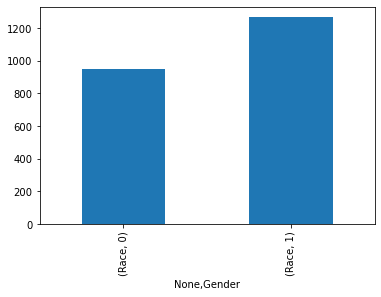

In [8]:
dfs2 = dfs1[['Gender','Race']]
dfs2.groupby(['Gender']).count().unstack().plot(kind='bar')

In each gender option data is not balanced for category race.

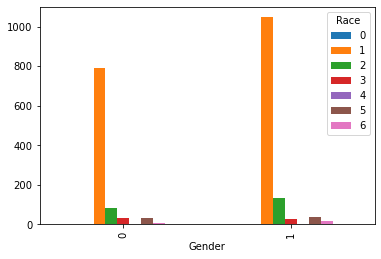

In [9]:
dfs2 = dfs1[['Gender','Race']]
dfs2.groupby(['Gender','Race'])['Gender'].count().unstack().plot(kind='bar')

Races are not balanced

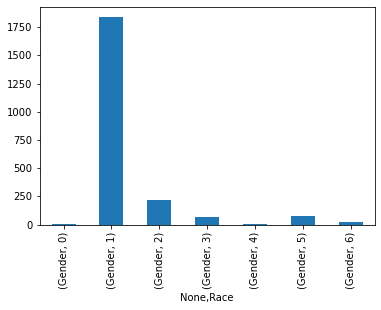

In [10]:
dfs2.groupby(['Race']).count().unstack().plot(kind='bar')

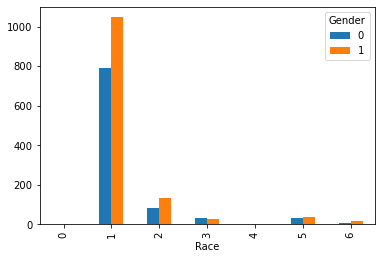

In [11]:
dfs2.groupby(['Race','Gender'])['Race'].count().unstack().plot(kind='bar')

counting for gender and Race, seperately

In [12]:
[dfs1[dfs1.Gender==i]['Gender'].count() for i in range(2)] # adds to 2222

[953, 1269]

In [13]:
[dfs1[dfs1.Race==i]['Race'].count() for i in range(0,7)] # adds to 2222

[2, 1836, 220, 63, 5, 72, 24]

In [14]:
[dfs1[dfs1.Race==0]] # race is undecided for these 2 images (both labeled male)

[                                    Filename  Image #  Gender       Age  Race
 342   Google_1_Clarence Morehouse_8_oval.jpg      343       1  4.750000     0
 1637        Google_1_Steven Mahan_1_oval.jpg     1638       1  3.833333     0]

In [ ]:
dfs3 = dfs1[['Gender','Race']]
dfs2.groupby(['Gender','Race'])['Gender'].count().unstack().plot(kind='bar')

Counting two characteristics, gender and race

In [17]:
# race==1 , gender==0
ct = 0
for i in dfs1.index:
    if dfs1.iloc[i].Gender==0 and dfs1.iloc[i].Race==1:
        ct+=1
print('white women : ' , ct)
# race==2 , gender==0
ct = 0
for i in dfs1.index:
    if dfs1.iloc[i].Gender==0 and dfs1.iloc[i].Race==2:
        ct+=1
print('black women : ' , ct)

white women :  789
black women :  84


coding for race and gender: 0=female 1=male , 0=undecided , 1=white

In [23]:
# minimum and maximum of age categories in data set
min(dfs1.Age) , max(dfs1.Age)

(1.0, 5.0)

In [57]:
dfs1[dfs1['Age'].isnull()]

,Filename,Image #,Gender,Age,Race
742,Brian_Friedrich_19_oval.jpg,743,1,NaN,1
800,Google_1_Aaron Osuna_9_oval.jpg,801,1,NaN,1
935,Google_1_Jonathan Bozarth_17_oval.jpg,936,1,NaN,1
1806,Google_1_Stephen Knudson_1_oval.jpg,1807,0,NaN,1


rounding to nearest integer :  1.0 1.0


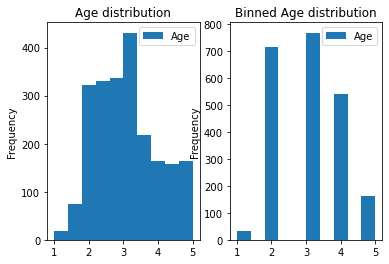

In [55]:
print('rounding to nearest integer : ' , round(1.1,0) , round(0.9,0))
dfs3 = dfs1[['Gender','Race','Age']]
plt.subplot(1, 2, 1)
dfs3['Age'].plot(kind='hist')
plt.title('Age distribution')
plt.legend()
plt.subplot(1, 2, 2)
dfs3['Age'].round().plot(kind='hist')
plt.title('Binned Age distribution')
plt.legend()

# Train and test images statistics

## Training images

In [18]:
!ls /home/jovyan/LFI/bainbridge_2k/images_train | wc -l
!ls /home/jovyan/LFI/bainbridge_2k/images_val | wc -l
!ls /home/jovyan/LFI/bainbridge_2k/images_test | wc -l

1998
102
108


In [20]:
dftt = pd.read_csv('../meta/labels2k_train_val_test.csv', index_col=0)
dftt.head()

,Filename,Image #,Gender,Age,Race,split,srtd
0,Google_1_Danielle Goble_5_oval.jpg,1,1,6.0,1,train,-1
1,Google_1_Phillip Owensby_9_oval.jpg,2,0,8.0,1,train,-1
2,Google_1_Douglas Ziegler_3_oval.jpg,3,1,6.0,1,train,-1
3,Google_1_Donald Sauls_11_oval.jpg,4,1,6.0,2,train,-1
4,Google_1_Eric Harman_5_oval.jpg,5,1,6.0,6,train,-1


In [21]:
dftt[dftt.split=='train'].shape , dftt[dftt.split=='val'].shape , dftt[dftt.split=='test'].shape 

((1998, 7), (102, 7), (108, 7))

Training set

In [22]:
df_train = dftt[dftt.split=='train']
N = df_train.shape[0]
print('in split : ' , N)
lm = df_train.Gender.sum()
lm ,N -lm , lm/N # labeled male, remaining , percentge labeled male

in split :  1998


(1153, 845, 0.5770770770770771)

57% labeled male as in the total 2k data set

In [23]:
lw = df_train[df_train['Race']==1] # labeled white (in train set)
W = lw.shape[0] # number of whites in training set
lm = lw.Gender.sum() # labeled male and white in the training set
lm, W-lm , lm/W # white males , white females , percentage of males in whites

(951, 702, 0.5753176043557169)

In [24]:
N - W # non whites in training set

345

Test set

In [27]:
df_val = dftt[dftt.split=='val']
N = df_val.shape[0]
print('in split : ' , N)
lm = df_val.Gender.sum()
lm ,N -lm , lm/N # labeled male, remaining , percentge labeled male

in split :  102


(61, 41, 0.5980392156862745)

In [28]:
df_test = dftt[dftt.split=='test']
N = df_test.shape[0]
print('in split : ' , N)
lm = df_test.Gender.sum()
lm ,N -lm , lm/N # labeled male, remaining , percentge labeled male

in split :  108


(49, 59, 0.4537037037037037)

In [15]:
lw = df_test[df_test['Race']==1] # labeled white (in test set)
W = lw.shape[0] # number of whites in test set
lwm = lw.Gender.sum() # labeled male and white in the test set
lwm, W-lwm , lwm/W # white males , white females , percentage of males in whites

(114, 70, 0.6195652173913043)

## age in test and in full data set

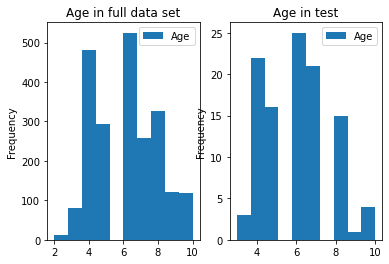

In [26]:
plt.subplot(1, 3, 1)
dftt['Age'].plot(kind='hist')
plt.title('Age in full data set')
plt.legend()
plt.subplot(1, 2, 2)
df_test['Age'].plot(kind='hist')
plt.title('Age in test')
plt.legend()
plt.subplot(1, 2, 3)
df_test['Age'].plot(kind='hist')
plt.title('Age in val')
plt.legend()

## race in test and in full data set

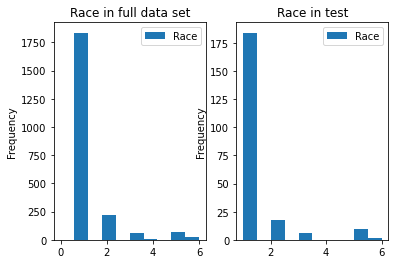

In [17]:
plt.subplot(1, 2, 1)
dftt['Race'].plot(kind='hist')
plt.title('Race in full data set')
plt.legend()
plt.subplot(1, 2, 2)
df_test['Race'].plot(kind='hist')
plt.title('Race in test')
plt.legend()